In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import time
from tqdm import tqdm

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV

np.random.seed(0)

# 1. Lendo dados 

In [2]:
link = 'https://docs.google.com/spreadsheets/d/1hyNndE4QVhjVLmB37ePBURRUkBlFUMJ3g6wlH2UenJY/edit#gid=516785925'
#df_dados = pd.read_csv(link)
df_dados = pd.read_csv("Customer-Churn - Customer-Churn.csv", decimal=',')

df_dados.head() 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,8672.45,No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,8477.60,No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,7990.05,No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,7365.70,No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,7804.15,Yes


## 1.2 Analise de integridade

**Analise de tipos**

In [3]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [93]:
df_dados['TotalCharges'].sum()

16056168.699999997

In [94]:
df_dados['MonthlyCharges'].mean()

64.76169246059918

**Analises simples**

In [4]:
# Dados numericos
df_dados.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [5]:
df_dados.describe(include=['object'])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7569-NMZYQ,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


# 2. Analise exploratoria

## 2.1 Analisando dados churn 

**Distribuição dos valores**

In [6]:
df_dados['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

<Axes: xlabel='Churn', ylabel='count'>

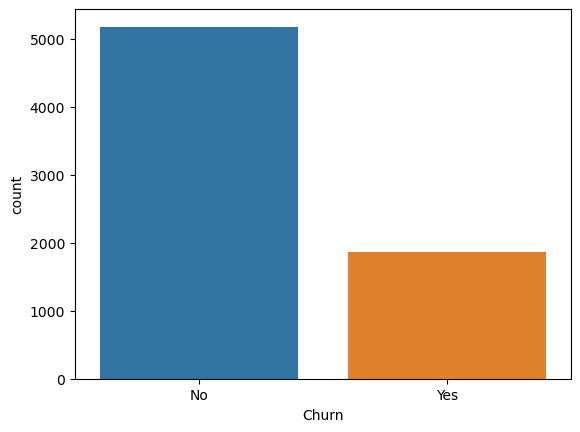

In [7]:
sns.countplot(df_dados,x='Churn')

<Axes: ylabel='Churn'>

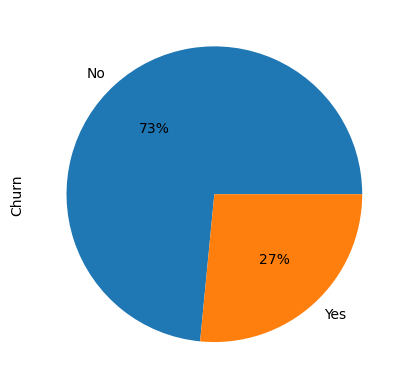

In [8]:
df_dados['Churn'].value_counts().plot(kind='pie', autopct='%1.0f%%')

**Correlação entre os dados numericos**

In [9]:
df_dados_modf = df_dados.copy()
df_dados_modf['Churn'] = np.where(df_dados_modf['Churn'] == 'No', 0, 1)
df_dados_num = df_dados_modf[['SeniorCitizen','tenure','MonthlyCharges','TotalCharges','Churn']]

In [10]:
df_corr = df_dados_num.corr()
df_corr

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.016567,0.220173,0.102411,0.150889
tenure,0.016567,1.000000,0.247900,0.825880,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.651065,0.193356
TotalCharges,0.102411,0.825880,0.651065,1.000000,-0.199484
Churn,0.150889,-0.352229,0.193356,-0.199484,1.000000


**Analise Numericos**

<Axes: xlabel='Churn', ylabel='TotalCharges'>

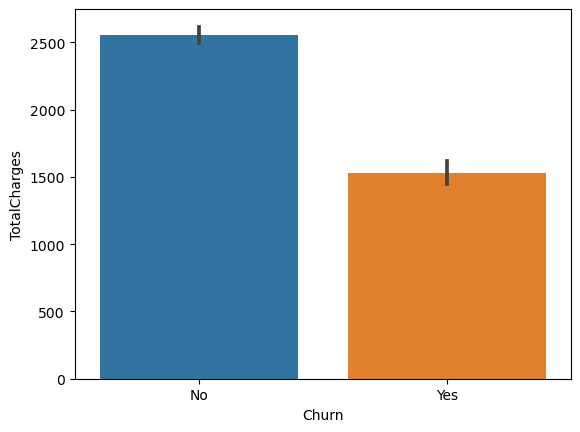

In [85]:
sns.barplot(df_dados, x='Churn',y='TotalCharges')

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

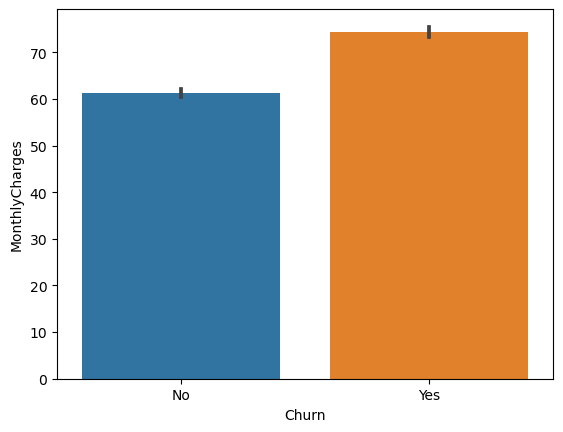

In [92]:
sns.barplot(df_dados, x='Churn',y='MonthlyCharges')

<Axes: xlabel='Churn', ylabel='tenure'>

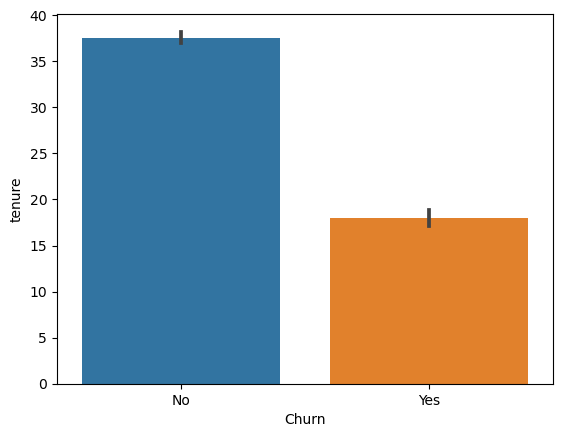

In [83]:
sns.barplot(df_dados, x='Churn',y='tenure')

<Axes: xlabel='Churn', ylabel='SeniorCitizen'>

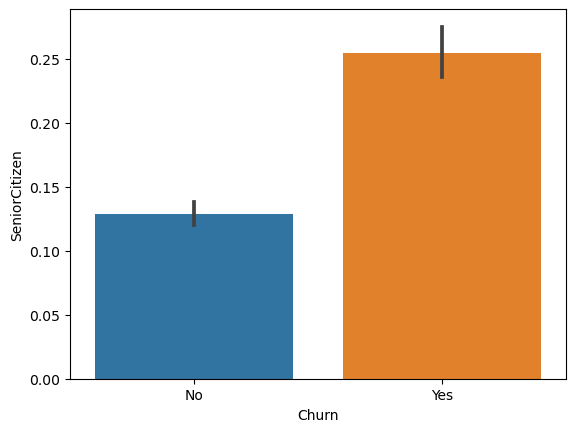

In [82]:
sns.barplot(df_dados, x='Churn',y='SeniorCitizen')

In [87]:
df_dados.groupby('Churn').mean()

C:\Users\vinic\AppData\Local\Temp\ipykernel_33476\3802313106.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dados.groupby('Churn').mean()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
Churn,,,,
No,0.128721,37.569965,61.265124,2555.344141
Yes,0.254682,17.979133,74.441332,1531.796094


In [91]:
df_dados['MonthlyCharges'].unique()

array([118.75, 118.65, 118.6 , ...,  18.55,  18.4 ,  18.25])

**Correlação dados categoricos**

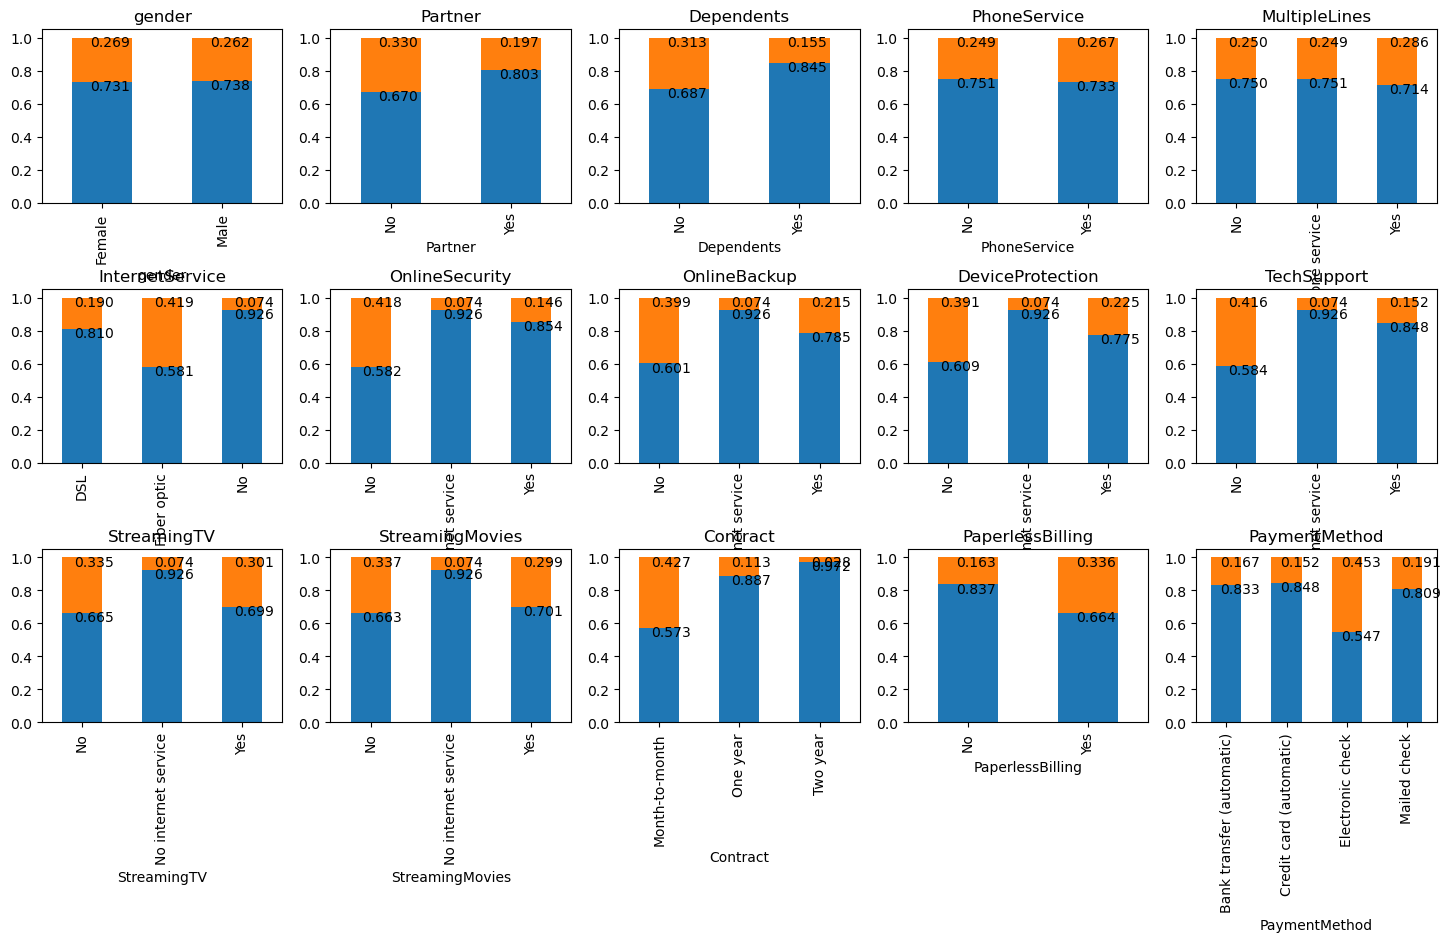

In [95]:
num_cat = 15
plt.figure(figsize=(18,9))

cont = 1
dict_pivot = {}
for column in df_dados:
    if df_dados[column].dtype == 'object' and column != 'customerID' and column != 'Churn':
        df = pd.pivot_table(df_dados, values='customerID',index=[column], columns=['Churn'], aggfunc='count')
        df = df.div(df.sum(axis=1),axis=0)  
        dict_pivot[column] = df
        
        ax = plt.subplot(3,5,cont);
        df.plot.bar(stacked=True, ax = ax, legend=False, title = column)
        plt.subplots_adjust(hspace=0.5)
        x_offset = -0.1
        y_offset = -0.05
        for p in ax.patches:
            b = p.get_bbox()
            val = "{:.3f}".format(round(b.y1 - b.y0,3))        
            ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset));
        cont += 1


In [96]:
dict_pivot['TechSupport']

Churn,No,Yes
TechSupport,,
No,0.583645,0.416355
No internet service,0.925950,0.074050
Yes,0.848337,0.151663


In [97]:
dict_pivot['Partner']

Churn,No,Yes
Partner,,
No,0.670420,0.329580
Yes,0.803351,0.196649


In [98]:
dict_pivot['InternetService']

Churn,No,Yes
InternetService,,
DSL,0.810409,0.189591
Fiber optic,0.581072,0.418928
No,0.925950,0.074050


In [99]:
dict_pivot['PaymentMethod']

Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),0.832902,0.167098
Credit card (automatic),0.847569,0.152431
Electronic check,0.547146,0.452854
Mailed check,0.808933,0.191067


# 3. Pre-Processing v1

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

**Limpando os dados**

In [14]:
def sep_data(df, y_column='Churn'):
    X = df.copy()
    y = X.pop(y_column)
    return X,y

def preprocessing_data(df, y_column='Churn', remove_columns=['customerID']):
    X,y = sep_data(df, y_column)
    # Convertendo y para inteiro  
    y = np.where(y == 'No', 0, 1)
    # Removendo colunas irrelevantes  
    X = X.drop(remove_columns, axis=1)
    # Convertendo dados texto para inteiro
    X = pd.get_dummies(X)
    X = X.fillna(0)
    return X,y

In [15]:
X,y = preprocessing_data(df_dados)

#  4. Criando Baseline e fluxo de machine learning

**Testando algoritmos**

In [16]:
dict_algo = {'RF':RandomForestClassifier(),
             'XGbost': XGBClassifier(),
             'DecisionTree': DecisionTreeClassifier(),
             'Perceptron': MLPClassifier(max_iter=700),
             'SVC':SVC()}

In [17]:
dict_scores = {}
list_time = []
for algo_name in dict_algo:
    print(f'{algo_name}...')
    clf = dict_algo[algo_name]
    start_time = time.time()
    scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
    end_time = time.time()
    list_time.append(end_time-start_time)
    dict_scores[algo_name] = scores

RF...
XGbost...
DecisionTree...
Perceptron...
SVC...


In [18]:
df_scores = pd.DataFrame(dict_scores).transpose()
df_scores['Mean'] = df_scores.mean(axis=1)
df_scores['Time'] = list_time
df_scores

,0,1,2,3,4,Mean,Time
RF,0.424829,0.416580,0.052632,0.049759,0.005333,0.189827,3.471956
XGbost,0.420461,0.197685,0.008975,0.046757,0.005333,0.135842,1.742210
DecisionTree,0.420934,0.240253,0.011670,0.060124,0.005333,0.147663,0.229474
Perceptron,0.310559,0.603070,0.503185,0.430859,0.005333,0.370601,3.920732
SVC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.041460


**Criando função para auxiliar os proximos passos**

In [19]:
def test_algos(dict_algo, X, y, scoring='f1', random_seed=0):
    #Garante que todos os exemplos tenham as mesmas divisões
    np.random.seed(random_seed)
    dict_scores = {}
    list_time = []
    for algo_name in dict_algo:
        print(f'{algo_name}...')
        clf = dict_algo[algo_name]
        start_time = time.time()
        scores = cross_val_score(clf, X, y, cv=5, scoring=scoring)
        end_time = time.time()
        dict_scores[algo_name] = scores
        list_time.append(end_time - start_time)
    df_scores = pd.DataFrame(dict_scores).transpose()
    df_scores['Mean'] = df_scores.mean(axis=1)
    df_scores['Time'] = list_time
    return df_scores

**Criando Função para comparar modelos**

In [20]:
columns=['best_model', 'best_score', 'mean_score','std_score','mean_time','std_time','time_best_alg']
df_models_comparation = pd.DataFrame(columns=columns)

def add_score(df_scores, name_test, df_models_comparation=df_models_comparation, columns=columns):
    best_model = df_scores['Mean'].idxmax()
    best_score = df_scores['Mean'].max()
    mean_score = df_scores['Mean'].mean()
    std_score = df_scores['Mean'].std()
    mean_time = df_scores['Time'].mean()
    std_time = df_scores['Time'].std()
    min_time = df_scores['Time'][best_model]
    df_line = pd.DataFrame([[best_model, best_score, mean_score, std_score, mean_time, std_time, min_time]], 
                             columns=columns, index=[name_test])
    df_output = pd.concat([df_models_comparation, df_line])
    return df_output

**Testando função**

In [21]:
df_scores = test_algos(dict_algo, X, y)
df_scores

RF...
XGbost...
DecisionTree...
Perceptron...
SVC...


,0,1,2,3,4,Mean,Time
RF,0.424829,0.416580,0.052632,0.049759,0.005333,0.189827,3.907552
XGbost,0.420461,0.197685,0.008975,0.046757,0.005333,0.135842,1.715513
DecisionTree,0.420934,0.240253,0.011670,0.060124,0.005333,0.147663,0.216371
Perceptron,0.310559,0.603070,0.503185,0.430859,0.005333,0.370601,3.863168
SVC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.963307


In [22]:
df_models_comparation = add_score(df_scores, 'df_scores', df_models_comparation)
df_models_comparation

,best_model,best_score,mean_score,std_score,mean_time,std_time,time_best_alg
df_scores,Perceptron,0.370601,0.168787,0.133409,3.733182,3.310607,3.863168


# 4. Melhorando Base 

**Balaceando target**

In [23]:
df_dados_true = df_dados[df_dados['Churn'] == 'Yes'] 
df_dados_false = df_dados[df_dados['Churn'] == 'No']
df_balanced = pd.concat([df_dados_false[:len(df_dados_true)], df_dados_true]).sample(frac = 1)

In [24]:
X_balanced, y_balanced = preprocessing_data(df_balanced)

In [25]:
df_balanced_score = test_algos(dict_algo, X_balanced, y_balanced)
df_balanced_score

RF...
XGbost...
DecisionTree...
Perceptron...
SVC...


,0,1,2,3,4,Mean,Time
RF,0.816552,0.805556,0.770745,0.808276,0.809328,0.802091,2.319650
XGbost,0.809264,0.779330,0.776371,0.785226,0.807163,0.791471,1.226189
DecisionTree,0.769025,0.729443,0.738095,0.768838,0.762155,0.753511,0.125600
Perceptron,0.759825,0.723697,0.753623,0.695327,0.792079,0.744910,2.341519
SVC,0.787551,0.771151,0.756164,0.779706,0.771350,0.773184,2.484144


In [26]:
df_models_comparation = add_score(df_balanced_score, 'df_balanced_score', df_models_comparation)
df_models_comparation

,best_model,best_score,mean_score,std_score,mean_time,std_time,time_best_alg
df_scores,Perceptron,0.370601,0.168787,0.133409,3.733182,3.310607,3.863168
df_balanced_score,RF,0.802091,0.773034,0.024271,1.699420,1.014104,2.319650


**Standardization dados**

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
df_stand = df_balanced.copy()

numerical_columns ='SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'
for column in numerical_columns:
    print(column)
    scaler = StandardScaler()
    column_trans = scaler.fit_transform(df_stand[[column]])
    df_stand[column] = np.squeeze(column_trans, axis=1)

SeniorCitizen
tenure
MonthlyCharges
TotalCharges


In [29]:
X_stand, y_stand = preprocessing_data(df_stand)

In [30]:
df_stand_score = test_algos(dict_algo, X_stand, y_stand)
df_stand_score

RF...
XGbost...
DecisionTree...
Perceptron...


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


SVC...


,0,1,2,3,4,Mean,Time
RF,0.816552,0.792768,0.767932,0.809458,0.804408,0.798223,2.368828
XGbost,0.819892,0.782369,0.776371,0.786885,0.795640,0.792232,1.223599
DecisionTree,0.770667,0.725828,0.739073,0.764479,0.761905,0.752390,0.125438
Perceptron,0.785515,0.774366,0.737430,0.775956,0.766977,0.768049,51.309637
SVC,0.824011,0.792916,0.789189,0.812921,0.809328,0.805673,2.243395


In [31]:
df_models_comparation = add_score(df_stand_score, 'df_stand_score', df_models_comparation)
df_models_comparation

,best_model,best_score,mean_score,std_score,mean_time,std_time,time_best_alg
df_scores,Perceptron,0.370601,0.168787,0.133409,3.733182,3.310607,3.863168
df_balanced_score,RF,0.802091,0.773034,0.024271,1.699420,1.014104,2.319650
df_stand_score,SVC,0.805673,0.783313,0.022311,11.454180,22.298233,2.243395


**Convertendo Colunas com dois valores (Ex. Yes/No) para binario**

In [32]:
df_convert = df_stand.copy()

dict_two_value_columns = {}
for column in df_convert:
    if df_convert[column].dtype == object and df_convert[column].nunique() == 2 and column != 'Churn': 
        dict_two_value_columns[column] = df_convert[column].unique()
print(dict_two_value_columns)

{'gender': array(['Male', 'Female'], dtype=object), 'Partner': array(['No', 'Yes'], dtype=object), 'Dependents': array(['No', 'Yes'], dtype=object), 'PhoneService': array(['Yes', 'No'], dtype=object), 'PaperlessBilling': array(['Yes', 'No'], dtype=object)}


In [33]:
for column in dict_two_value_columns:
    list_data = dict_two_value_columns[column]
    variable_1 = 'Yes' if 'Yes' in  list_data else list_data[0] 
    df_convert[column] = np.where(df_convert[column] == variable_1, 1, 0)

In [34]:
X_convert, y_convert = preprocessing_data(df_convert)
df_convert_score = test_algos(dict_algo, X_convert, y_convert)
df_convert_score

RF...
XGbost...
DecisionTree...
Perceptron...


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


SVC...


,0,1,2,3,4,Mean,Time
RF,0.810056,0.794444,0.776078,0.808276,0.811475,0.800066,2.348588
XGbost,0.817439,0.782369,0.760446,0.786885,0.801653,0.789758,1.195101
DecisionTree,0.772487,0.733775,0.733154,0.771795,0.755614,0.753365,0.109997
Perceptron,0.784530,0.776471,0.750663,0.778833,0.789062,0.775912,47.925595
SVC,0.824011,0.794558,0.790257,0.810229,0.809264,0.805664,2.188422


In [35]:
df_models_comparation = add_score(df_convert_score, 'df_convert_score', df_models_comparation)
df_models_comparation

,best_model,best_score,mean_score,std_score,mean_time,std_time,time_best_alg
df_scores,Perceptron,0.370601,0.168787,0.133409,3.733182,3.310607,3.863168
df_balanced_score,RF,0.802091,0.773034,0.024271,1.699420,1.014104,2.319650
df_stand_score,SVC,0.805673,0.783313,0.022311,11.454180,22.298233,2.243395
df_convert_score,SVC,0.805664,0.784953,0.020976,10.753540,20.799128,2.188422


**Obervando features com 3 caracteristicas**

In [36]:
df_convert_2 = df_convert.copy()

dict_three_value_columns = {}
for column in df_convert:
    if df_convert_2[column].dtype == object and df_convert_2[column].nunique() == 3 and column != 'Churn': 
        dict_three_value_columns[column] = df_convert_2[column].unique()

for column in dict_three_value_columns:       
    print(column, dict_three_value_columns[column])

MultipleLines ['Yes' 'No' 'No phone service']
InternetService ['Fiber optic' 'DSL' 'No']
OnlineSecurity ['Yes' 'No' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'Two year' 'One year']


In [37]:
for column in dict_two_value_columns:
    list_data = dict_two_value_columns[column] 
    if 'Yes' in list_data and 'No' in list_data: 
        df_convert_2[column] = np.where(df_convert[column] == 'Yes', 1, np.where(df_convert[column] == 'No', 0, -1))

In [38]:
X_convert_2, y_convert_2 = preprocessing_data(df_convert_2)
df_convert_2_score = test_algos(dict_algo, X_convert_2, y_convert_2)
df_convert_2_score

RF...
XGbost...
DecisionTree...
Perceptron...
SVC...


,0,1,2,3,4,Mean,Time
RF,0.816438,0.782247,0.766252,0.797829,0.793388,0.791231,2.309212
XGbost,0.810298,0.779944,0.771784,0.797799,0.809524,0.793870,1.179006
DecisionTree,0.782493,0.759259,0.740541,0.757333,0.765789,0.761083,0.109927
Perceptron,0.808054,0.770235,0.771277,0.786189,0.798408,0.786832,35.518499
SVC,0.818554,0.801083,0.790323,0.806971,0.809717,0.805329,1.992327


In [39]:
df_models_comparation = add_score(df_convert_2_score, 'df_convert_2_score', df_models_comparation)
df_models_comparation

,best_model,best_score,mean_score,std_score,mean_time,std_time,time_best_alg
df_scores,Perceptron,0.370601,0.168787,0.133409,3.733182,3.310607,3.863168
df_balanced_score,RF,0.802091,0.773034,0.024271,1.699420,1.014104,2.319650
df_stand_score,SVC,0.805673,0.783313,0.022311,11.454180,22.298233,2.243395
df_convert_score,SVC,0.805664,0.784953,0.020976,10.753540,20.799128,2.188422
df_convert_2_score,SVC,0.805329,0.787669,0.016359,8.221794,15.282983,1.992327


# Label Selection 

**Observando correlação**

In [40]:
X_corr = X_convert.copy()
df_corr = X_corr.corr()
df_corr.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
gender,1.000000,-0.018072,0.026748,0.013485,0.013915,-0.012957,-0.013603,-0.014485,0.007533,-0.004579,...,0.003172,0.001657,-0.003708,-0.003749,0.005892,-0.001131,-0.027376,-0.017047,0.030533,0.008329
SeniorCitizen,-0.018072,1.000000,0.023555,-0.208298,-0.003039,-0.013614,0.110606,0.080598,0.006487,-0.091918,...,-0.001301,-0.078675,0.028617,0.115176,-0.030262,-0.113042,-0.034806,-0.034298,0.117431,-0.093144
Partner,0.026748,0.023555,1.000000,0.408139,0.411213,0.055580,-0.009621,0.232946,0.398913,-0.154468,...,-0.152262,-0.081054,0.178526,-0.296696,0.120099,0.249890,0.117034,0.089970,-0.092063,-0.114774
Dependents,0.013485,-0.208298,0.408139,1.000000,0.181680,0.052801,-0.074631,0.056977,0.169655,-0.002835,...,-0.054801,0.003905,0.052762,-0.196618,0.064713,0.180181,0.082010,0.063772,-0.120525,0.003580
tenure,0.013915,-0.003039,0.411213,0.181680,1.000000,0.148406,-0.003683,0.530236,0.973556,-0.361616,...,-0.341641,-0.172842,0.397436,-0.714729,0.302952,0.588606,0.242171,0.261867,-0.267253,-0.213556


In [41]:
num_itens = len(df_corr.columns)
thresold = 0.95

matrix_similares = []
for cont_row in range(0, num_itens-1):
    for cont_line in range(cont_row+1, num_itens-1):
        linha = df_corr.index[cont_line] 
        row = df_corr.columns[cont_row]
        if df_corr[linha][row] > thresold:
            matrix_similares.append([linha, row, df_corr[linha][row]])

df_remove_itens = pd.DataFrame(matrix_similares, columns=['item_1', 'item_2', 'valor'])
list_itens_remove = df_remove_itens['item_2'].unique()
list_itens_remove

array(['tenure', 'InternetService_No',
       'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service',
       'DeviceProtection_No internet service',
       'TechSupport_No internet service',
       'StreamingTV_No internet service'], dtype=object)

In [42]:
X_clean = X_corr.drop(list_itens_remove, axis=1)

In [73]:
X_clean.shape

(3738, 33)

In [43]:
df_corr_score = test_algos(dict_algo, X_clean, y_convert)
df_corr_score

RF...
XGbost...
DecisionTree...
Perceptron...


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


SVC...


,0,1,2,3,4,Mean,Time
RF,0.804438,0.784530,0.776536,0.798343,0.804979,0.793765,2.257068
XGbost,0.801097,0.781032,0.768156,0.787380,0.804408,0.788415,1.141508
DecisionTree,0.771466,0.741633,0.732510,0.778489,0.747368,0.754293,0.094148
Perceptron,0.789404,0.776280,0.763298,0.785714,0.767160,0.776371,54.290706
SVC,0.826739,0.799458,0.790823,0.804845,0.813605,0.807094,3.122592


In [44]:
df_models_comparation = add_score(df_corr_score, 'df_corr_score', df_models_comparation)
df_models_comparation

,best_model,best_score,mean_score,std_score,mean_time,std_time,time_best_alg
df_scores,Perceptron,0.370601,0.168787,0.133409,3.733182,3.310607,3.863168
df_balanced_score,RF,0.802091,0.773034,0.024271,1.699420,1.014104,2.319650
df_stand_score,SVC,0.805673,0.783313,0.022311,11.454180,22.298233,2.243395
df_convert_score,SVC,0.805664,0.784953,0.020976,10.753540,20.799128,2.188422
df_convert_2_score,SVC,0.805329,0.787669,0.016359,8.221794,15.282983,1.992327
df_corr_score,SVC,0.807094,0.783988,0.019930,12.181204,23.567610,3.122592


**Boruta**

In [45]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
X_boruta = X_convert.copy().values
y_boruta = y_convert.copy().ravel()

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=5)

feat_selector = BorutaPy(clf, random_state=42, verbose=0)

# find all relevant features - 5 features should be selected
feat_selector.fit(X_boruta, y_boruta)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = X_convert[X_convert.columns[feat_selector.support_]]

In [74]:
X_filtered.shape

(3738, 25)

In [46]:
df_boruta_score = test_algos(dict_algo, X_filtered, y_convert)
df_boruta_score

RF...
XGbost...
DecisionTree...
Perceptron...
SVC...


,0,1,2,3,4,Mean,Time
RF,0.821282,0.779944,0.784741,0.797241,0.807640,0.798170,2.410618
XGbost,0.804945,0.775453,0.773743,0.800000,0.803256,0.791480,1.083637
DecisionTree,0.769231,0.769640,0.737968,0.765563,0.777174,0.763915,0.100156
Perceptron,0.811554,0.758523,0.778378,0.790761,0.802244,0.788292,34.908466
SVC,0.814208,0.805970,0.789688,0.809019,0.805930,0.804963,1.872504


In [47]:
df_models_comparation = add_score(df_boruta_score, 'df_boruta', df_models_comparation)
df_models_comparation

,best_model,best_score,mean_score,std_score,mean_time,std_time,time_best_alg
df_scores,Perceptron,0.370601,0.168787,0.133409,3.733182,3.310607,3.863168
df_balanced_score,RF,0.802091,0.773034,0.024271,1.699420,1.014104,2.319650
df_stand_score,SVC,0.805673,0.783313,0.022311,11.454180,22.298233,2.243395
df_convert_score,SVC,0.805664,0.784953,0.020976,10.753540,20.799128,2.188422
df_convert_2_score,SVC,0.805329,0.787669,0.016359,8.221794,15.282983,1.992327
df_corr_score,SVC,0.807094,0.783988,0.019930,12.181204,23.567610,3.122592
df_boruta,SVC,0.804963,0.789364,0.015606,8.075076,15.025548,1.872504


**Utilizando Feature importance**

In [48]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
X_feat_importance = X_convert.copy()
y_feat_importance = y_convert.copy()

forest = RandomForestClassifier()

forest.fit(X_filtered, y_feat_importance)
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_filtered.columns)

In [49]:
forest_importances.describe()

count    25.000000
mean      0.040000
std       0.069726
min       0.002432
25%       0.010699
50%       0.014056
75%       0.023594
max       0.264120
dtype: float64

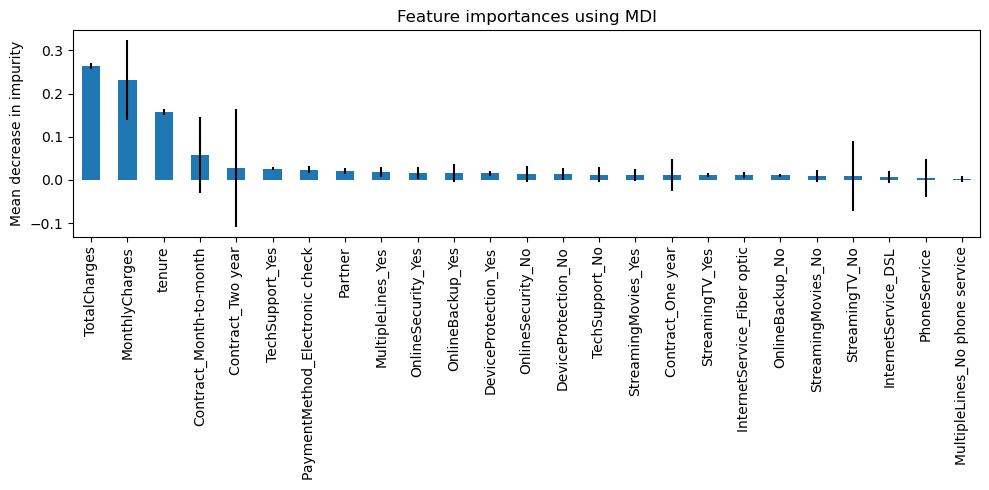

In [50]:
forest_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(10,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Analisando numero ideal**

In [51]:
# Aux function

def test_alg(clf, X, y):
    start_time = time.time()
    scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
    end_time = time.time()
    return scores.mean(), end_time - start_time

In [52]:
forest_importances.sort_values(ascending=False, inplace=True)
list_features = []
list_metrics = []
clf = SVC()

for feat in tqdm(forest_importances.index):
    list_features.append(feat)
    X_feats = X_convert[list_features]
    metrics = test_alg(clf, X_feats, y_convert)
    list_metrics.append(metrics)

df_comparation = pd.DataFrame(list_metrics, columns=['f1_score','time'])

100%|██████████████████████████████████████████████████████████████████████████| 25/25 [00:53<00:00,  2.14s/it]


In [75]:
X_best_feats.shape

(3738, 13)

In [53]:
df_comparation['f1_score'].idxmax(), df_comparation['f1_score'].max()

(14, 0.8081659962782627)

In [54]:
best_feats = list_features[:13]
X_best_feats = X_convert[best_feats]
df_best_feats_score = test_algos(dict_algo, X_best_feats, y_convert)
df_best_feats_score

RF...
XGbost...
DecisionTree...
Perceptron...
SVC...


,0,1,2,3,4,Mean,Time
RF,0.817680,0.773296,0.777778,0.792190,0.812672,0.794723,2.283160
XGbost,0.810667,0.784916,0.763889,0.802740,0.797799,0.792002,0.997948
DecisionTree,0.781579,0.755674,0.730871,0.765563,0.786003,0.763938,0.090368
Perceptron,0.814614,0.801619,0.766667,0.815825,0.809461,0.801637,37.378120
SVC,0.824324,0.802183,0.788618,0.811245,0.811398,0.807554,1.754658


In [55]:
df_models_comparation = add_score(df_best_feats_score, 'df_best_feats', df_models_comparation)
df_models_comparation

,best_model,best_score,mean_score,std_score,mean_time,std_time,time_best_alg
df_scores,Perceptron,0.370601,0.168787,0.133409,3.733182,3.310607,3.863168
df_balanced_score,RF,0.802091,0.773034,0.024271,1.699420,1.014104,2.319650
df_stand_score,SVC,0.805673,0.783313,0.022311,11.454180,22.298233,2.243395
df_convert_score,SVC,0.805664,0.784953,0.020976,10.753540,20.799128,2.188422
df_convert_2_score,SVC,0.805329,0.787669,0.016359,8.221794,15.282983,1.992327
df_corr_score,SVC,0.807094,0.783988,0.019930,12.181204,23.567610,3.122592
df_boruta,SVC,0.804963,0.789364,0.015606,8.075076,15.025548,1.872504
df_best_feats,SVC,0.807554,0.791971,0.016805,8.500851,16.163982,1.754658


**Utilizando PCA sobre todas as features**

In [56]:
from sklearn.decomposition import PCA
list_features = []
list_metrics = []
clf = SVC()

for num_feats in tqdm(range(1, len(X_convert.columns))):
    pca = PCA(n_components=num_feats)
    X_pca = pca.fit_transform(X_convert)
    metrics = test_alg(clf, X_pca, y_convert)
    list_metrics.append(metrics)

df_comparation = pd.DataFrame(list_metrics, columns=['f1_score','time'])
best_num_pca = df_comparation['f1_score'].idxmax()+1
print("Melhor metrica:", df_comparation['f1_score'].max(), "Numero de parametros:", best_num_pca)

100%|██████████████████████████████████████████████████████████████████████████| 39/39 [01:17<00:00,  1.99s/it]

Melhor metrica: 0.8059175897897329 Numero de parametros: 20


In [76]:
pca = PCA(n_components=best_num_pca)
X_pca = pca.fit_transform(X_convert)
df_pca = test_algos(dict_algo, X_pca, y_convert)
df_pca

RF...
XGbost...
DecisionTree...
Perceptron...


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multi

SVC...


,0,1,2,3,4,Mean,Time
RF,0.793914,0.778689,0.754144,0.795048,0.774898,0.779338,8.227072
XGbost,0.788966,0.766938,0.764626,0.789189,0.781421,0.778228,1.982175
DecisionTree,0.732543,0.713158,0.704762,0.748336,0.729023,0.725564,0.331867
Perceptron,0.773585,0.770861,0.755376,0.776439,0.772789,0.769810,52.929976
SVC,0.827869,0.796726,0.789757,0.802139,0.813097,0.805918,1.779421


In [77]:
df_models_comparation = add_score(df_pca, 'df_pca', df_models_comparation)
df_models_comparation

,best_model,best_score,mean_score,std_score,mean_time,std_time,time_best_alg
df_scores,Perceptron,0.370601,0.168787,0.133409,3.733182,3.310607,3.863168
df_balanced_score,RF,0.802091,0.773034,0.024271,1.699420,1.014104,2.319650
df_stand_score,SVC,0.805673,0.783313,0.022311,11.454180,22.298233,2.243395
df_convert_score,SVC,0.805664,0.784953,0.020976,10.753540,20.799128,2.188422
df_convert_2_score,SVC,0.805329,0.787669,0.016359,8.221794,15.282983,1.992327
df_corr_score,SVC,0.807094,0.783988,0.019930,12.181204,23.567610,3.122592
df_boruta,SVC,0.804963,0.789364,0.015606,8.075076,15.025548,1.872504
df_best_feats,SVC,0.807554,0.791971,0.016805,8.500851,16.163982,1.754658
df_pca,SVC,0.807554,0.791971,0.016805,8.544581,16.237415,1.775950
df_pca_2,SVC,0.807554,0.791971,0.016805,8.601890,16.340341,1.775953


**Utilizando PCA sobre melhores as features**

In [78]:
from sklearn.decomposition import PCA
list_features = []
list_metrics = []
clf = SVC()

for num_feats in tqdm(range(1, len(X_best_feats.columns))):
    pca = PCA(n_components=num_feats)
    X_pca = pca.fit_transform(X_best_feats)
    metrics = test_alg(clf, X_pca, y_convert)
    list_metrics.append(metrics)

df_comparation_2 = pd.DataFrame(list_metrics, columns=['f1_score','time'])
best_num_pca_2 = df_comparation_2['f1_score'].idxmax()+1
print(df_comparation_2['f1_score'].max(), best_num_pca)

100%|██████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.78s/it]

0.8073352847051913 20


In [79]:
pca = PCA(n_components=best_num_pca_2)
X_pca_2 = pca.fit_transform(X_best_feats)
df_pca_2 = test_algos(dict_algo, X_pca_2, y_convert)
df_pca_2

RF...
XGbost...
DecisionTree...
Perceptron...


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\neural_network\_multi

SVC...


,0,1,2,3,4,Mean,Time
RF,0.801664,0.766434,0.781421,0.797260,0.799443,0.789244,6.277853
XGbost,0.796748,0.747613,0.766304,0.784574,0.769231,0.772894,1.521670
DecisionTree,0.748031,0.747051,0.727513,0.729730,0.756972,0.741860,0.203971
Perceptron,0.809202,0.770289,0.784946,0.800000,0.802667,0.793421,50.572815
SVC,0.824324,0.800546,0.790761,0.810160,0.810884,0.807335,1.601510


In [80]:
df_models_comparation = add_score(df_pca_2, 'df_pca_2', df_models_comparation)
df_models_comparation

,best_model,best_score,mean_score,std_score,mean_time,std_time,time_best_alg
df_scores,Perceptron,0.370601,0.168787,0.133409,3.733182,3.310607,3.863168
df_balanced_score,RF,0.802091,0.773034,0.024271,1.699420,1.014104,2.319650
df_stand_score,SVC,0.805673,0.783313,0.022311,11.454180,22.298233,2.243395
df_convert_score,SVC,0.805664,0.784953,0.020976,10.753540,20.799128,2.188422
df_convert_2_score,SVC,0.805329,0.787669,0.016359,8.221794,15.282983,1.992327
df_corr_score,SVC,0.807094,0.783988,0.019930,12.181204,23.567610,3.122592
df_boruta,SVC,0.804963,0.789364,0.015606,8.075076,15.025548,1.872504
df_best_feats,SVC,0.807554,0.791971,0.016805,8.500851,16.163982,1.754658
df_pca,SVC,0.807554,0.791971,0.016805,8.544581,16.237415,1.775950
df_pca_2,SVC,0.807554,0.791971,0.016805,8.601890,16.340341,1.775953


# 5. Tunning

**Obs:** Para o tunning será usado a base de PCA, com 20 componetes, pois demonstrou ter a melhor performace/tempo, e será analisado os dois melhores algoritmo (SVM e RandoForest). Enquanto para escolha dos hyperparametros será utilizando o o metodo bayesian search. 

**Tunning SVM**

In [62]:
from sklearn.model_selection import StratifiedKFold
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

clf = SVC()

ITERATIONS = 10

search_paramns = {
                  'C': Real(1e-6, 1e+6, prior='log-uniform'),
                  'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
                  'degree': Integer(1,8),
                  'kernel': Categorical(['linear', 'poly', 'rbf']),
                }

cv = StratifiedKFold(n_splits=5, shuffle=True)

bayes_cv_tuner = BayesSearchCV(estimator=clf, search_spaces=search_paramns, refit = True,
                               scoring='f1', cv=cv, n_iter = ITERATIONS)

In [63]:
from skopt.callbacks import VerboseCallback
callback = VerboseCallback(0)

Iteration No: 1 started. Searching for the next optimal point.


In [64]:
start = time.time()
# Fit the model
result_cpu = bayes_cv_tuner.fit(X_pca, y_convert, callback=callback)
time_model_cpu = round(time.time() - start, 3)
print(f"Tempo cpu:{time_model_cpu}")

Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 4.1319
Function value obtained: -0.7765
Current minimum: -0.7765
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 6.0328
Function value obtained: -0.4489
Current minimum: -0.7765
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 12.2280
Function value obtained: -0.7566
Current minimum: -0.7765
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 14.1454
Function value obtained: -0.4485
Current minimum: -0.7765
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 16.2029
Function value obtained: -0.2394
Current minimum: -0.7765
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 18.5115
Function value obtained: -0.7936
Current minimum: -0.7936
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 22.0299
Function value obtained: -0.7274
Current mini

**Tuning Random Forest**

In [65]:
rf_clf = RandomForestClassifier()

ITERATIONS = 20

search_paramns = {
                     'bootstrap': (True, False),
                     'max_depth': (10, 10000, 'log-uniform'),
                     'max_features': ('auto', 'sqrt'),
                     'min_samples_leaf': (1, 5, 'log-uniform'),
                     'min_samples_split': (2, 10, 'log-uniform'),
                     'n_estimators': (100, 2000, 'log-uniform')
                }

cv = StratifiedKFold(n_splits=5, shuffle=True)

bayes_cv_tuner = BayesSearchCV(estimator=rf_clf, search_spaces=search_paramns, refit = True,
                               scoring='f1', cv=cv, n_iter = ITERATIONS)

In [66]:
start = time.time()
# Fit the model
result_cpu = bayes_cv_tuner.fit(X_pca, y_convert, callback=callback)
time_model_cpu = round(time.time() - start, 3)
print(f"Tempo cpu:{time_model_cpu}")

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 64.9439
Function value obtained: -0.7752
Current minimum: -0.7752
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 84.3149
Function value obtained: -0.7812
Current minimum: -0.7812
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 122.2996
Function value obtained: -0.7823
Current minimum: -0.7823
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 207.3197
Function value obtained: -0.7864
Current minimum: -0.7864


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 213.6554
Function value obtained: -0.7894
Current minimum: -0.7894


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 271.6799
Function value obtained: -0.7946
Current minimum: -0.7946


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 291.7397
Function value obtained: -0.7961
Current minimum: -0.7961
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 316.0113
Function value obtained: -0.7904
Current minimum: -0.7961
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 333.6940
Function value obtained: -0.7891
Current minimum: -0.7961
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 342.3412
Function value obtained: -0.7823
Current minimum: -0.7961


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 449.2522
Function value obtained: -0.7905
Current minimum: -0.7961


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 463.8205
Function value obtained: -0.7874
Current minimum: -0.7961


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 531.8868
Function value obtained: -0.7947
Current minimum: -0.7961


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 540.9018
Function value obtained: -0.7965
Current minimum: -0.7965


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 560.5256
Function value obtained: -0.7876
Current minimum: -0.7965


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 634.6665
Function value obtained: -0.7982
Current minimum: -0.7982
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 718.6776
Function value obtained: -0.8050
Current minimum: -0.8050
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 817.3952
Function value obtained: -0.7999
Current minimum: -0.8050
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 853.1373
Function value obtained: -0.7935
Current minimum: -0.8050


C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\vinic\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 883.6349
Function value obtained: -0.7896
Current minimum: -0.8050
Tempo cpu:874.453


In [69]:
result_cpu.best_params_

OrderedDict([('bootstrap', True),
             ('max_depth', 10),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 1),
             ('min_samples_split', 9),
             ('n_estimators', 1582)])

In [70]:
result_cpu.best_score_

0.8049714629336606

In [71]:
print(f"fit_time:{result_cpu.cv_results_['mean_fit_time'].mean()}")
print(f"score_time:{result_cpu.cv_results_['mean_score_time'].mean()}")
print(f"rank_score:{result_cpu.cv_results_['rank_test_score']}")

fit_time:8.25540269613266
score_time:0.1533572340011597
rank_score:[20 19 17 16 12  7  5 10 13 18  9 15  6  4 14  3  1  2  8 11]


In [68]:
X_convert.shape

(3738, 40)